<a href="https://colab.research.google.com/github/pacslab/conc-value-perf-modelling/blob/main/experiments/parser/ConcValueExpParser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing The Notebook

In this section, we will be preparing the environment to run the code in.

## Mount Google Drive and Create Static Links

In [17]:
# mount drive to get started
from google.colab import drive
drive.mount('/mnt/drive')

# create static links to the drive folder
!sudo ln -sf /mnt/drive/MyDrive/Colab\ Notebooks/conc_val_res results

Mounted at /mnt/drive


In [16]:
# # unmount drive when we are done
# drive.flush_and_unmount()
# print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


## Install Necessary Dependencies

In [3]:
%%writefile requirements.txt

pacswg>=0.1.16
pacsltk>=0.1.13
tqdm>=4.36.1

Overwriting requirements.txt


In [4]:
!pip install -q -r requirements.txt

In [5]:
# import tqdm
import tqdm

# quietly deep-reload tqdm
import sys
from IPython.lib import deepreload 

stdout = sys.stdout
sys.stdout = open('junk','w')
deepreload.reload(tqdm)
sys.stdout = stdout

## Imports and Initializations

In [6]:
# plotting imports (needs to be before matplotlib)
import pacsltk.pacs_util as pacs_util
pacs_util.prepare_matplotlib_cycler()

# general imports
import os

# parsing imports
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# other seaborn aesthetic options: http://seaborn.pydata.org/tutorial/aesthetics.html
sns.set_style("whitegrid")

# for datetime analysis
from datetime import datetime
import pytz

# for file processing
import glob
import json

# for better printing of variables
from IPython.display import display

## Utility Functions

In [7]:
def save_json_file(data, filename):
    with open(filename, 'w') as outfile:
        json.dump(data, outfile)

def load_json_file(filename):
    with open(filename) as json_file:
        data = json.load(json_file)
    return data

# Plotting Arrival Rate Plots

In [13]:
# all constants
results_folder = './results/'
my_timezone = 'US/Eastern'

# Prepare for plots and make directories
figs_folder = "figs"
!rm -r {figs_folder}
!mkdir -p {figs_folder}

In [9]:
def get_fig_path(x): return (os.path.join(figs_folder, "exp" +
              x + ".png"), os.path.join(figs_folder, "exp" + x + ".pdf"))

def tmp_fig_save(fig_name):
    paths = get_fig_path(fig_name)
    plt.savefig(paths[0], dpi=300)
    plt.savefig(paths[1])

## Developing Analysis of An Experiment Log

In [10]:
# list all results
csv_file_list = glob.glob(f'{results_folder}*.csv')
exp_list = list(map(lambda x: x.replace(results_folder, '').replace('.csv',''), csv_file_list))
print('List of Experiments Analyzing:\n')
exp_list

List of Experiments Analyzing:



['res-2020-12-12_00-00-11',
 'res-2020-12-11_22-59-57',
 'res-2020-12-11_23-40-07',
 'res-2020-12-12_00-20-16',
 'res-2020-12-11_22-39-49',
 'res-2020-12-11_22-19-40',
 'res-2020-12-11_23-20-02']

info data:


{'concurrency_limit': 0.0,
 'concurrency_target': 1.0,
 'concurrency_target_utilization': 70.0,
 'rps': 6,
 'rps_list': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]}

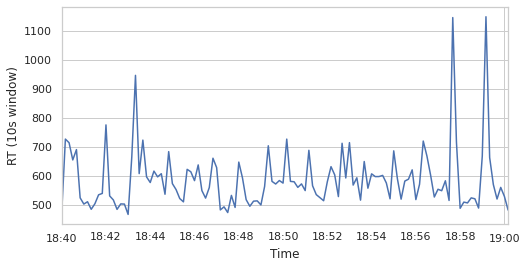

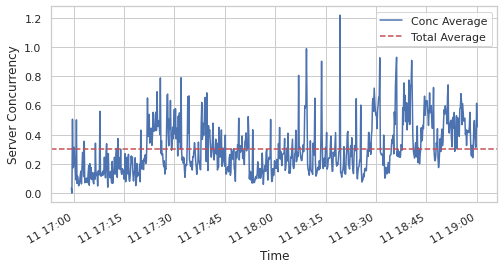

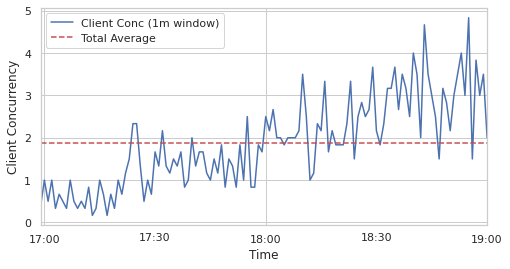

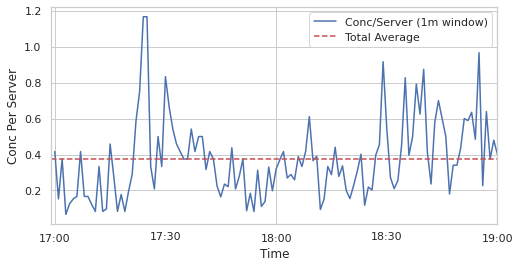

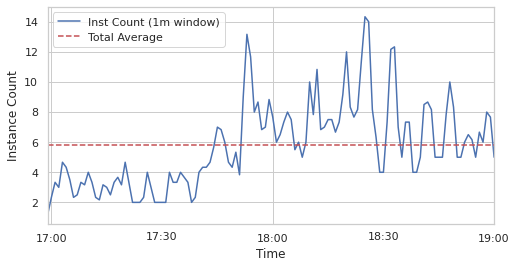

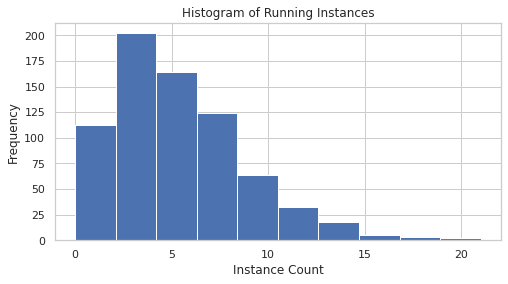

In [96]:
# parsing functions
def load_exp_file(exp_name, results_folder=results_folder):
  csv_file = f'{results_folder}{exp_name}.csv'
  df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
  df['client_elapsed_time'] = df['client_elapsed_time'] * 1000
  epoch_cols_list = ['client_start_time', 'client_end_time',]
  datetimes = {}
  for epoch_col in epoch_cols_list:
      times = df[epoch_col].apply(lambda x: datetime.fromtimestamp(x).astimezone(pytz.timezone(my_timezone)).replace(tzinfo=None))
      times = pd.to_datetime(times.dt.to_pydatetime())
      df[epoch_col + '_dt'] = times
      datetimes[epoch_col] = times

  df = df.set_index('client_start_time_dt')
  return df

def load_exp_json_files(exp_name, results_folder=results_folder):
  results = []
  # load all postfixes
  for pf in ['_conc.json', '_stats.json', '_info.json']:
    results.append(load_json_file(results_folder + exp_name + pf))
  # return the results as tuple
  return tuple(results)

def convert_timestamp(ts):
  return datetime.fromtimestamp(ts/1000).astimezone(pytz.timezone(my_timezone)).replace(tzinfo=None)

def convert_hist_to_values(h):
  # get values based on estimated hist fetched
  values = []
  for x,y in zip(h['x'], h['y']):
    values += [x] * int(y)
  return values

def plot_client_data(exp_df_client, window='10s'):
  plt.figure(figsize=(8,4))
  exp_df_client['client_elapsed_time'].resample(window).mean().plot()
  plt.ylabel(f'RT ({window} window)')
  plt.xlabel('Time')
  tmp_fig_save("_" + exp_name + "_rt")

def parse_conc_data(conc_data):
  conc_df = pd.DataFrame(data=conc_data)
  conc_df['report_time'] = conc_df['report_time'].apply(convert_timestamp)
  conc_df = conc_df.set_index(conc_df['report_time'])

  client_conc_per_server = conc_df['client_conc'] / conc_df['running_instance_count']
  # we need to remove inf because server count might be zero
  client_conc_per_server = client_conc_per_server.replace([np.inf, -np.inf], np.nan)
  conc_df['client_conc_per_server'] = client_conc_per_server

  conc_df['client_conc'] = conc_df['start_conc']

  return conc_df

def plot_server_conc(conc_df):
  server_conc_avg = conc_df['avg'].mean()

  plt.figure(figsize=(8,4))
  conc_df['avg'].plot(label='Conc Average')
  plt.xlabel('Time')
  plt.ylabel('Server Concurrency')
  plt.axhline(y=server_conc_avg, c='r', ls='--', label='Total Average')
  plt.legend()
  tmp_fig_save("_" + exp_name + "_server_conc")

def plot_client_conc(conc_df, client_conc_avg):
  plt.figure(figsize=(8,4))
  conc_df['client_conc'].resample('1T').mean().plot(label='Client Conc (1m window)')
  plt.axhline(y=client_conc_avg, c='r', ls='--', label='Total Average')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Client Concurrency')
  tmp_fig_save("_" + exp_name + "_client_conc")

def plot_conc_per_server(conc_df, client_conc_per_server_avg):
  plt.figure(figsize=(8,4))
  client_conc_per_server.resample('1T').mean().plot(label='Conc/Server (1m window)')
  plt.xlabel('Time')
  plt.ylabel('Conc Per Server')
  plt.axhline(y=client_conc_per_server_avg, c='r', ls='--', label='Total Average')
  plt.legend()
  tmp_fig_save("_" + exp_name + "_conc_per_server")

def plot_running_inst_count(conc_df, inst_count_avg):
  plt.figure(figsize=(8,4))
  conc_df['running_instance_count'].resample('1T').mean().plot(label='Inst Count (1m window)')
  plt.axhline(y=inst_count_avg, c='r', ls='--', label='Total Average')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Instance Count')
  tmp_fig_save("_" + exp_name + "_inst_count")

  plt.figure(figsize=(8,4))
  plt.title('Histogram of Running Instances')
  plt.hist(conc_df['running_instance_count'])
  plt.xlabel('Instance Count')
  plt.ylabel('Frequency')
  tmp_fig_save("_" + exp_name + "_inst_count_hist")

#################################################
# running sample parsing

debug = False

exp_name = exp_list[0]
conc_data, stats_data, info_data = load_exp_json_files(exp_name)

# adding extra metadata and print
info_data['rps'] = info_data['rps_list'][0]
print('info data:')
display(info_data)

# plot data from client
exp_df_client = load_exp_file(exp_name)
if debug:
  print('Experiment Client Dataframe:')
  display(exp_df_client.head())
plot_client_data(exp_df_client)

# parse concurrency data
conc_df = parse_conc_data(conc_data)
if debug:
  print('Concurrency Dataframe:')
  display(conc_df.head())

# plot server concurrency
plot_server_conc(conc_df)
# plot client concurrency
client_conc_avg = conc_df['client_conc'].mean()
plot_client_conc(conc_df, client_conc_avg)
# plot conc per server
client_conc_per_server_avg = conc_df['client_conc_per_server'].mean()
plot_conc_per_server(conc_df, client_conc_per_server_avg)

# plot number of running instances
inst_count_avg = conc_df['running_instance_count'].mean()
plot_running_inst_count(conc_df, inst_count_avg)

# plot long-term service time and server concurrency histogram
# TODO